In [1]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import polars as pl
import altair as alt
import mplfinance as mpf
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from scipy import stats

In [2]:
pdf_raw = pd.read_parquet("data/silver/stock_daily_candle.parquet")

In [3]:
data = pdf_raw
data = data[(data["ticker"] == "TSLA") & (data["date"] > date(2025, 1, 1))].sort_values(
    "date"
)
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data = data.sort_index()
data["idx"] = np.arange(0, data.shape[0])

# Now, plot the candlestick chart
# mpf.plot(data, type="candle", style="yahoo", volume=True, mav=(10, 20))

In [4]:
df_raw = pl.read_parquet("data/silver/stock_daily_candle.parquet")

In [113]:
df = df_raw
df = df.filter(pl.sql_expr("ticker = 'TSLA' AND date > DATE '2025-01-01'"))
df = df.with_columns(
    pl.col("open").alias("nat_open"),
    pl.col("high").alias("nat_high"),
    pl.col("low").alias("nat_low"),
    pl.col("close").alias("nat_close"),
    pl.col("open").log(2).alias("open"),
    pl.col("high").log(2).alias("high"),
    pl.col("low").log(2).alias("low"),
    pl.col("close").log(2).alias("close"),
)
WINDOW = 5
df = df.with_columns(
    pl.int_range(pl.len()).over(partition_by="ticker", order_by="date").alias("idx"),
    pl.col("low")
    .le(pl.col("low").rolling_min(window_size=WINDOW * 2 + 1, center=True))
    .over(partition_by="ticker", order_by="date")
    .fill_null(False)
    .alias("is_low_peak"),
    pl.col("high")
    .ge(pl.col("high").rolling_max(window_size=WINDOW * 2 + 1, center=True))
    .over(partition_by="ticker", order_by="date")
    .fill_null(False)
    .alias("is_high_peak"),
    pl.col("close")
    .le(pl.col("close").rolling_min(window_size=WINDOW * 2 + 1, center=True))
    .over(partition_by="ticker", order_by="date")
    .fill_null(False)
    .alias("is_close_low_peak"),
    pl.col("close")
    .ge(pl.col("close").rolling_max(window_size=WINDOW * 2 + 1, center=True))
    .over(partition_by="ticker", order_by="date")
    .fill_null(False)
    .alias("is_close_high_peak"),
)
df.sort("idx").select(
    "idx",
    "high",
    "low",
    "is_low_peak",
    "is_high_peak",
    "is_close_low_peak",
    "is_close_high_peak",
).limit(10)

idx,high,low,is_low_peak,is_high_peak,is_close_low_peak,is_close_high_peak
i64,f64,f64,bool,bool,bool,bool
0,8.617394,8.543187,false,false,false,false
1,8.68608,8.567766,false,false,false,false
2,8.736165,8.649975,false,false,false,false
3,8.694636,8.60733,false,false,false,false
4,8.652845,8.59768,false,false,false,false
5,8.641257,8.55953,false,false,false,false
6,8.657461,8.570121,false,false,false,false
7,8.723286,8.624028,false,false,false,false
8,8.747522,8.664127,false,false,false,true


In [114]:
dqd

index,idx,channel_parr_1,channel_parr_2,channel_parr_3,channel_high_1,channel_high_2,channel_high_3,channel_low_1,channel_low_2,channel_low_3,type
u32,i64,struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],str
0,144,null,null,null,null,null,null,null,"{7.336522,0.006122,0.999987,0.000031}",null,"""low"""
1,156,null,null,null,"{6.811772,0.010256,1.0,0.0}",null,null,null,null,null,"""high"""
2,57,null,null,null,null,null,"{8.025295,0.003014,0.750406,0.0008}",null,null,null,"""high"""
3,125,null,"{7.767191,0.003921,0.721902,0.000285}",null,null,null,null,null,null,null,"""parr"""
4,135,null,null,null,null,"{8.108678,0.002146,0.749476,0.00134}",null,null,null,null,"""high"""
5,105,null,null,null,null,null,null,null,null,"{7.665116,0.004041,0.985471,0.000348}","""low"""
6,165,"{3.930037,0.02684,0.830064,0.004819}",null,null,null,null,null,null,null,null,"""parr"""
7,157,null,null,null,null,null,null,"{7.324328,0.006198,1.0,0.0}",null,null,"""low"""
8,45,null,null,"{7.813248,0.003949,0.747995,0.000158}",null,null,null,null,null,null,"""parr"""


In [115]:
tmp = df.sort("idx").clone()

tmp_parr = pl.concat(
    [
        tmp.select("idx", pl.col("open").alias("value")),
        tmp.select("idx", pl.col("close").alias("value")),
        tmp.select("idx", pl.col("high").alias("value")),
        tmp.select("idx", pl.col("low").alias("value")),
    ]
).sort("idx")

tmp_higher = (
    tmp.filter(
        pl.sql_expr(
            "is_high_peak = TRUE AND is_low_peak <> TRUE"  # AND idx > MAX(idx) - 90"
        )
    )
    .select("idx", "high")
    .sort("idx")
    .to_numpy()
)
tmp_lower = (
    tmp.filter(
        pl.sql_expr(
            "is_high_peak <> TRUE AND is_low_peak = TRUE"  # AND idx > MAX(idx) - 90"
        )
    )
    .select("idx", "low")
    .sort("idx")
    .to_numpy()
)
tmp_idx = np.hstack([tmp_lower[:, 0], tmp_higher[:, 0]])
reg_p = pl.DataFrame(
    [
        np.hstack(
            [
                tmp.select("idx", "high")[int(i)].to_numpy()[0],
                list(
                    stats.linregress(*tmp_parr.filter(pl.col("idx").ge(i)).to_numpy().T)
                ),
            ]
        )
        for i in tmp_idx
    ],
    {
        "idx": pl.Int64,
        "max": pl.Float64,
        "slope": pl.Float64,
        "intercept": pl.Float64,
        "r_val": pl.Float64,
        "p_val": pl.Float64,
        "stderr": pl.Float64,
    },
    orient="row",
)

reg_h = pl.DataFrame(
    [
        np.hstack(
            [
                tmp_higher[i],
                list(stats.linregress(tmp_higher[i:, 0], tmp_higher[i:, 1])),
            ]
        )
        for i in range(tmp_higher.shape[0] - 1)
    ],
    {
        "idx": pl.Int64,
        "max": pl.Float64,
        "slope": pl.Float64,
        "intercept": pl.Float64,
        "r_val": pl.Float64,
        "p_val": pl.Float64,
        "stderr": pl.Float64,
    },
    orient="row",
)
reg_l = pl.DataFrame(
    [
        np.hstack(
            [
                tmp_lower[i],
                list(stats.linregress(tmp_lower[i:, 0], tmp_lower[i:, 1])),
            ]
        )
        for i in range(tmp_lower.shape[0] - 1)
    ],
    {
        "idx": pl.Int64,
        "max": pl.Float64,
        "slope": pl.Float64,
        "intercept": pl.Float64,
        "r_val": pl.Float64,
        "p_val": pl.Float64,
        "stderr": pl.Float64,
    },
    orient="row",
)
channel_struct_n = lambda s, n: (
    pl.when(pl.col("index").eq(n - 1) & pl.col("type").eq(s))
    .then(
        pl.struct(
            pl.col("intercept"),
            pl.col("slope"),
            pl.col("r_val"),
            pl.col("stderr"),
        )
    )
    .over(order_by="idx")
    .alias(f"channel_{s}_{n}")
)
ddf = (
    pl.concat(
        [
            reg_l.with_columns(pl.lit("low").alias("type")),
            reg_h.with_columns(pl.lit("high").alias("type")),
            reg_p.with_columns(pl.lit("parr").alias("type")),
        ]
    )
    .with_columns(
        (pl.col("r_val")).alias("score") 
    )
    # .with_columns(
    #     (pl.col("r_val") * (pl.max("idx") - pl.col("idx")).log(10)).alias("score")
    # )
    # .with_columns(
    #     (pl.col("r_val") * (pl.max("idx") - pl.col("idx")).pow(0.2)).alias("score")
    # )
    .with_columns(
        pl.row_index().over(partition_by="type", order_by="score", descending=True)
    )
    .filter(pl.col("index").lt(3))
    .with_columns(
        pl.row_index()
        .over(partition_by="type", order_by="idx", descending=True)
        .alias("index")
    )
    .with_columns(
        channel_struct_n("low", 1),
        channel_struct_n("low", 2),
        channel_struct_n("low", 3),
        channel_struct_n("high", 1),
        channel_struct_n("high", 2),
        channel_struct_n("high", 3),
        channel_struct_n("parr", 1),
        channel_struct_n("parr", 2),
        channel_struct_n("parr", 3),
    )
)
# ddf.filter(pl.col("r_val") == pl.max("r_val")).select("idx")
ddf = (
    ddf.group_by("idx")
    .agg(
        *[
            pl.col(f"channel_{c}_{i}").drop_nulls().first()
            for c in ("parr", "high", "low")
            for i in (1, 2, 3)
        ],
        pl.first("type"),
    )
    .with_row_index()
)
dqd = ddf
ddf = ddf.sort("idx")
ddf = df.sort("idx").join(
    ddf, on="idx", how="left"
)
channel_line_n = (
    lambda ct, id: pl.col(f"channel_{ct}_{id}")
    .forward_fill()
    .struct.with_fields(
        (
            pl.col("idx")
            * pl.col(f"channel_{ct}_{id}").forward_fill().struct.field("slope")
            + pl.col(f"channel_{ct}_{id}").forward_fill().struct.field("intercept")
        ).alias("line")
    )
)
ddf = ddf.with_columns(
    channel_line_n("low", 1),
    channel_line_n("low", 2),
    channel_line_n("low", 3),
    channel_line_n("high", 1),
    channel_line_n("high", 2),
    channel_line_n("high", 3),
    channel_line_n("parr", 1),
    channel_line_n("parr", 2),
    channel_line_n("parr", 3),
)
# reg_h
ddf
# stats.linregress(tmp_lower.select("idx"), tmp_lower.select("low"))
# tmp_lower
ddf.filter(pl.col("idx").gt(42)).select(
    "idx",
    pl.col("channel_high_1").struct.unnest(),
    pl.col("channel_low_1").struct.field("line").alias("l"),
    pl.col("channel_parr_3").struct.field("line").alias("ll"),
    "index",
)

idx,intercept,slope,r_val,stderr,line,l,ll,index
i64,f64,f64,f64,f64,f64,f64,f64,u32
43,null,null,null,null,null,null,null,null
44,null,null,null,null,null,null,null,null
45,null,null,null,null,null,null,7.990955,6
46,null,null,null,null,null,null,7.994905,null
47,null,null,null,null,null,null,7.998854,null
…,…,…,…,…,…,…,…,…
164,8.047868,0.002626,1.0,0.0,8.478511,8.339955,8.460894,null
165,8.047868,0.002626,1.0,0.0,8.481137,8.346038,8.464843,null
166,8.047868,0.002626,1.0,0.0,8.483763,8.352121,8.468792,null


In [116]:
dqd
# ddf.filter(pl.col("idx").gt(40)).select(pl.col("channel_high_1").struct.unnest())

index,idx,channel_parr_1,channel_parr_2,channel_parr_3,channel_high_1,channel_high_2,channel_high_3,channel_low_1,channel_low_2,channel_low_3,type
u32,i64,struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],str
0,152,null,null,null,"{8.047868,0.002626,1.0,0.0}",null,null,null,null,null,"""high"""
1,135,null,null,null,null,"{8.038649,0.002684,0.999963,0.000023}",null,null,null,null,"""high"""
2,125,null,"{7.767191,0.003921,0.721902,0.000285}",null,null,null,null,null,"{7.713922,0.003661,0.95188,0.000833}",null,"""low"""
3,57,null,null,null,null,null,"{8.095696,0.002561,0.725561,0.001086}",null,null,null,"""high"""
4,144,null,null,null,null,null,null,"{7.342356,0.006083,1.0,0.0}",null,null,"""low"""
5,138,"{7.595936,0.004994,0.710632,0.000448}",null,null,null,null,null,null,null,null,"""parr"""
6,45,null,null,"{7.813248,0.003949,0.747995,0.000158}",null,null,null,null,null,null,"""parr"""
7,105,null,null,null,null,null,null,null,null,"{7.702185,0.003742,0.983516,0.000397}","""low"""


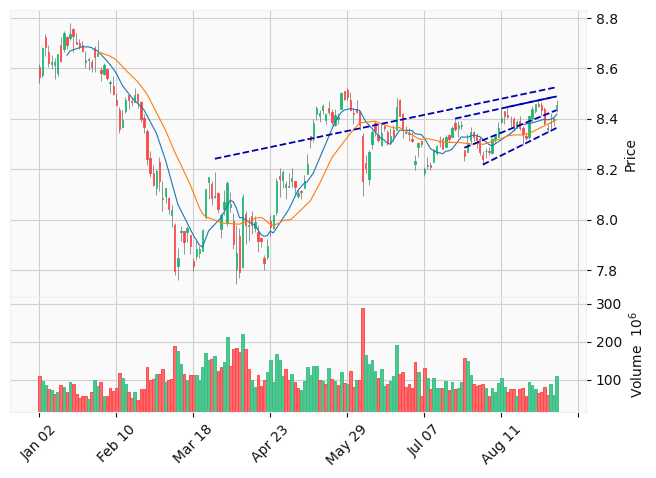

In [ ]:
# Add MACD as subplot
date_filter = "2023-01-01"


df_data = ddf.to_pandas()
df_data = df_data.set_index("date")
df_data["channel_parr_1"] = ddf.select(pl.col("channel_parr_1").struct.field("line"))
df_data["channel_parr_2"] = ddf.select(pl.col("channel_parr_2").struct.field("line"))
df_data["channel_parr_3"] = ddf.select(pl.col("channel_parr_3").struct.field("line"))
df_data["channel_high_1"] = ddf.select(pl.col("channel_high_1").struct.field("line"))
# df_data["channel_high_1"][df_data.index < datetime(2025,8,18)] = None
df_data["channel_high_2"] = ddf.select(pl.col("channel_high_2").struct.field("line"))
df_data["channel_high_3"] = ddf.select(pl.col("channel_high_3").struct.field("line"))
df_data["channel_low_1"] = ddf.select(pl.col("channel_low_1").struct.field("line"))
df_data["channel_low_2"] = ddf.select(pl.col("channel_low_2").struct.field("line"))
df_data["channel_low_3"] = ddf.select(pl.col("channel_low_3").struct.field("line"))
df_data["idx"] = np.arange(0, df_data.shape[0])

bar_plot = lambda data, color: mpf.make_addplot(data, type="bar", color=color, panel=2)
extra_plots = [
    # mpf.make_addplot((chnl["channel_high"]), linestyle="--", color="#111111", panel=0),
    # mpf.make_addplot((chnl["channel_low"]), linestyle="--", color="#111111", panel=0),
    mpf.make_addplot(
        df_data["channel_parr_1"], linestyle="--", color="#0000aa", panel=0
    ),
    # mpf.make_addplot(
    #     df_data["channel_parr_2"], linestyle="--", color="#0000aa", panel=0
    # ),
    # mpf.make_addplot(
    #     df_data["channel_parr_3"], linestyle="--", color="#0000aa", panel=0
    # ),
    mpf.make_addplot(
        df_data["channel_high_1"], linestyle="--", color="#0000aa", panel=0
    ),
    # mpf.make_addplot(
    #     df_data["channel_high_2"], linestyle="--", color="#0000aa", panel=0
    # ),
    # mpf.make_addplot(
    #     df_data["channel_high_3"], linestyle="--", color="#0000aa", panel=0
    # ),
    mpf.make_addplot(
        df_data["channel_low_1"], linestyle="--", color="#0000aa", panel=0
    ),
    # mpf.make_addplot(
    #     df_data["channel_low_2"], linestyle="--", color="#00aaaa", panel=0
    # ),
    # mpf.make_addplot(
    #     df_data["channel_low_3"], linestyle="--", color="#aaaaaa", panel=0
    # ),
]

mpf.plot(
    df_data[df_data.index > date_filter],
    type="candle",
    style="yahoo",
    volume=True,
    addplot=extra_plots,
    mav=(10, 20),
    savefig="stock_chart.svg",
)

mpf.plot(
    df_data[df_data.index > date_filter],
    type="candle",
    style="yahoo",
    volume=True,
    addplot=extra_plots,
    mav=(10, 20),
)

In [25]:
df_data["channel_high_1"][df_data.index > datetime(2025,3,5)]

date
2025-03-06         NaN
2025-03-07         NaN
2025-03-10         NaN
2025-03-11    7.273296
2025-03-12    7.283552
                ...   
2025-08-29    8.493772
2025-09-02    8.504028
2025-09-03    8.514284
2025-09-04    8.524540
2025-09-05    8.534796
Name: channel_high_1, Length: 127, dtype: float64

In [1027]:
1.4**2

1.9599999999999997

In [582]:
def is_pivot(df, index, window):
    if index < window or index >= df.shape[0] - window:
        return 0
    pivot_low = 2 * ~(
        df.iloc[index].low > df.iloc[index - window : index + window + 1].low.min()
    )
    pivot_high = 1 * ~(
        df.iloc[index].high < df.iloc[index - window : index + window + 1].high.max()
    )
    return pivot_high + pivot_low


# def pointpos(x):
#     if x["is_pivot"] == 2:
#         return x["low"] - 1e-3
#     elif x["is_pivot"] == 1:
#         return x["high"] + 1e-3


def collect_channel(df, date: datetime, channel_length: timedelta, window):
    localdf = df[(df.index <= date) & (df.index > date - channel_length)].copy(
        deep=True
    )

    localdf["is_pivot"] = [
        is_pivot(localdf, i, window) for i in range(localdf.shape[0])
    ]
    # localdf["pointpos"] = localdf.apply(lambda row: pointpos(row), axis=1)

    highs = localdf[localdf["is_pivot"] == 1].high.values
    idxhighs = localdf[localdf["is_pivot"] == 1].idx
    lows = localdf[localdf["is_pivot"] == 2].low.values
    idxlows = localdf[localdf["is_pivot"] == 2].idx

    sl_lows, interc_lows, r_value_l, _, _ = stats.linregress(idxlows, lows)
    sl_highs, interc_highs, r_value_h, _, _ = stats.linregress(idxhighs, highs)

    df["channel_high"] = interc_highs + df.idx * sl_highs
    df.loc[df.index < date - channel_length - timedelta(5), "channel_high"] = None
    df["channel_low"] = interc_lows + df.idx * sl_lows
    df.loc[df.index < date - channel_length - timedelta(5), "channel_low"] = None
    return df


def parallell_channel(
    df, date: datetime, channel_length: timedelta, std_factor: int = 1
):
    filter_date = (df.index <= date) & (df.index > date - channel_length)
    df_local = df[filter_date].copy(deep=True)
    print(df.shape, df_local.shape)
    df_local = df_local.set_index("idx")
    df_new = pd.DataFrame()
    df_new["val"] = pd.concat(
        [df_local.open, df_local.high, df_local.low, df_local.close], axis=0
    )
    regression = stats.linregress(df_new.index, df_new.val)
    df_new["reg_error"] = df_new["val"] - (
        regression.intercept + df_new.index * regression.slope
    )
    std_value = df_new.reg_error.std()
    print(df_new.reg_error)
    print(std_value)
    df["parallel_channel"] = regression.intercept + df.idx * regression.slope
    df["parallel_channel_upper"] = df["parallel_channel"] + std_value * std_factor
    df["parallel_channel_lower"] = df["parallel_channel"] - std_value * std_factor
    df.loc[
        ~filter_date,
        ("parallel_channel", "parallel_channel_upper", "parallel_channel_lower"),
    ] = None
    return df


parallell_channel(data, datetime(2025, 9, 5), timedelta(30))

(169, 12) (21, 12)
idx
148   -10.431646
149    -9.394283
150     3.573105
151    12.970484
152     8.867864
         ...    
164    -5.993583
165   -11.106213
166    -6.978823
167    -3.141440
168     8.565937
Name: reg_error, Length: 84, dtype: float64
9.478791015252954


,ticker,high,low,open,close,volume,idx,channel_high,channel_low,parallel_channel,parallel_channel_upper,parallel_channel_lower
date,,,,,,,,,,,,
2025-01-02,TSLA,392.730011,373.040009,390.100006,379.279999,109710700.0,0,NaN,NaN,NaN,NaN,NaN
2025-01-03,TSLA,411.880005,379.450012,381.480011,410.440002,95423300.0,1,NaN,NaN,NaN,NaN,NaN
2025-01-06,TSLA,426.429993,401.700012,423.200012,411.049988,85516500.0,2,NaN,NaN,NaN,NaN,NaN
2025-01-07,TSLA,414.329987,390.000000,405.829987,394.359985,75699500.0,3,NaN,NaN,NaN,NaN,NaN
2025-01-08,TSLA,402.500000,387.399994,392.950012,394.940002,73038800.0,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-29,TSLA,348.750000,331.700012,347.230011,333.869995,81145700.0,164,340.661242,317.620811,339.863579,349.34237,330.384788
2025-09-02,TSLA,333.329987,325.600006,328.230011,329.359985,58392000.0,165,340.408025,318.403727,340.466199,349.94499,330.987408
2025-09-03,TSLA,343.329987,328.510010,335.200012,334.089996,88733300.0,166,340.154808,319.186642,341.068819,350.54761,331.590028


(169, 12) (45, 12)
idx
124    0.055063
125   -0.074839
126   -0.051002
127   -0.052106
128   -0.043808
         ...   
164   -0.025560
165   -0.048954
166   -0.032156
167   -0.016882
168    0.030874
Name: reg_error, Length: 180, dtype: float64
0.04790868044689253


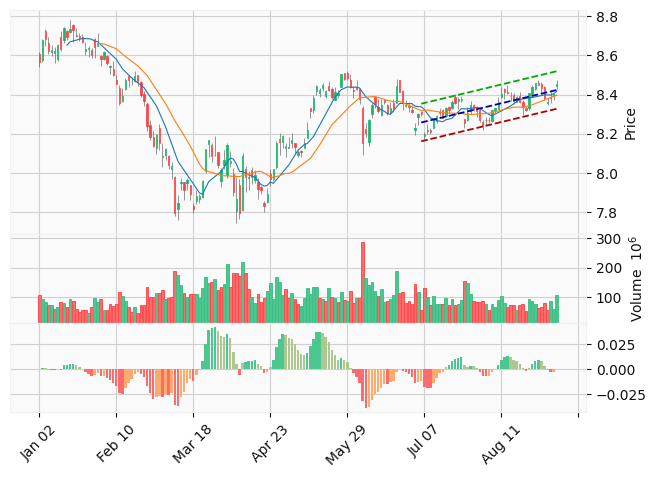

In [813]:
# Add MACD as subplot
date_filter = "2023-01-01"


def MACD(df, window_slow, window_fast, window_signal):
    macd = pd.DataFrame()
    macd["ema_slow"] = df["close"].ewm(span=window_slow).mean()
    macd["ema_fast"] = df["close"].ewm(span=window_fast).mean()
    macd["macd"] = macd["ema_slow"] - macd["ema_fast"]
    macd["signal"] = macd["macd"].ewm(span=window_signal).mean()
    macd["diff"] = macd["macd"] - macd["signal"]
    macd["is_incr"] = macd["diff"].abs() > macd["diff"].shift(1, fill_value=0).abs()
    macd["bar_positive_increasing"] = macd["diff"][macd.is_incr].map(
        lambda x: x if x > 0 else 0
    )
    macd["bar_positive_diminish"] = macd["diff"][~macd.is_incr].map(
        lambda x: x if x > 0 else 0
    )
    macd["bar_negative_increasing"] = macd["diff"][macd.is_incr].map(
        lambda x: x if x < 0 else 0
    )
    macd["bar_negative_diminish"] = macd["diff"][~macd.is_incr].map(
        lambda x: x if x < 0 else 0
    )
    return macd


df_data = data.copy(deep=True)
df_data["open"] = np.log2(df_data["open"])
df_data["high"] = np.log2(df_data["high"])
df_data["low"] = np.log2(df_data["low"])
df_data["close"] = np.log2(df_data["close"])

df_data["idx"] = np.arange(0, df_data.shape[0])
macd = MACD(df_data, 12, 26, 9)
macd = macd[df_data.index > date_filter]
chnl = collect_channel(df_data, datetime(2025, 9, 5), timedelta(days=60), 7)
chnl = parallell_channel(df_data, datetime(2025, 9, 5), timedelta(days=65), 2)
chnl = chnl[df_data.index > date_filter]
df_data
# print(chnl)

bar_plot = lambda data, color: mpf.make_addplot(data, type="bar", color=color, panel=2)
extra_plots = [
    mpf.make_addplot(
        (macd["macd"]), color="#606060", panel=1, ylabel="MACD", secondary_y=False
    ),
    mpf.make_addplot((macd["signal"]), color="#1f77b4", panel=1, secondary_y=False),
    bar_plot(macd["bar_positive_increasing"], "#4dc790"),
    bar_plot(macd["bar_positive_diminish"], "#adc790"),
    bar_plot(macd["bar_negative_increasing"], "#fd6b6c"),
    bar_plot(macd["bar_negative_diminish"], "#fdab6c"),
    # mpf.make_addplot((chnl["channel_high"]), linestyle="--", color="#111111", panel=0),
    # mpf.make_addplot((chnl["channel_low"]), linestyle="--", color="#111111", panel=0),
    mpf.make_addplot(
        (chnl["parallel_channel"]), linestyle="--", color="#0000aa", panel=0
    ),
    mpf.make_addplot(
        (chnl["parallel_channel_upper"]), linestyle="--", color="#00aa00", panel=0
    ),
    mpf.make_addplot(
        (chnl["parallel_channel_lower"]), linestyle="--", color="#aa0000", panel=0
    ),
]

mpf.plot(
    df_data[df_data.index > date_filter],
    type="candle",
    style="yahoo",
    volume=True,
    addplot=extra_plots,
    mav=(10, 20),
    savefig="stock_chart.svg",
)

mpf.plot(
    df_data[df_data.index > date_filter],
    type="candle",
    style="yahoo",
    volume=True,
    addplot=extra_plots,
    mav=(10, 20),
)

In [121]:
from ipywidgets import interact

In [130]:
def plot_func(channel):
    # Add MACD as subplot
    date_filter = "2025-06-01"

    df_data = ddf.to_pandas()
    df_data = df_data.set_index("date")
    df_data["channel_parr_1"] = ddf.select(pl.col("channel_parr_1").struct.field("line"))
    df_data["channel_parr_2"] = ddf.select(pl.col("channel_parr_2").struct.field("line"))
    df_data["channel_parr_3"] = ddf.select(pl.col("channel_parr_3").struct.field("line"))
    df_data["channel_high_1"] = ddf.select(pl.col("channel_high_1").struct.field("line"))
    # df_data["channel_high_1"][df_data.index < datetime(2025,8,18)] = None
    df_data["channel_high_2"] = ddf.select(pl.col("channel_high_2").struct.field("line"))
    df_data["channel_high_3"] = ddf.select(pl.col("channel_high_3").struct.field("line"))
    df_data["channel_low_1"] = ddf.select(pl.col("channel_low_1").struct.field("line"))
    df_data["channel_low_2"] = ddf.select(pl.col("channel_low_2").struct.field("line"))
    df_data["channel_low_3"] = ddf.select(pl.col("channel_low_3").struct.field("line"))
    df_data["idx"] = np.arange(0, df_data.shape[0])
    df_data = df_data[df_data.index > date_filter]

    bar_plot = lambda data, color: mpf.make_addplot(data, type="bar", color=color, panel=2)
    extra_plots = [
        # mpf.make_addplot((chnl["channel_high"]), linestyle="--", color="#111111", panel=0),
        # mpf.make_addplot((chnl["channel_low"]), linestyle="--", color="#111111", panel=0),
        mpf.make_addplot(
            df_data[f"channel_parr_{channel}"], linestyle="--", color="#0000aa", panel=0
        ),
        mpf.make_addplot(
            df_data[f"channel_high_{channel}"], linestyle="--", color="#0000aa", panel=0
        ),
        mpf.make_addplot(
            df_data[f"channel_low_{channel}"], linestyle="--", color="#0000aa", panel=0
        ),
        # mpf.make_addplot(
        #     df_data["channel_parr_2"], linestyle="--", color="#0000aa", panel=0
        # ),
        # mpf.make_addplot(
        #     df_data["channel_parr_3"], linestyle="--", color="#0000aa", panel=0
        # ),
        # mpf.make_addplot(
        #     df_data["channel_high_2"], linestyle="--", color="#0000aa", panel=0
        # ),
        # mpf.make_addplot(
        #     df_data["channel_high_3"], linestyle="--", color="#0000aa", panel=0
        # ),
        # mpf.make_addplot(
        #     df_data["channel_low_2"], linestyle="--", color="#00aaaa", panel=0
        # ),
        # mpf.make_addplot(
        #     df_data["channel_low_3"], linestyle="--", color="#aaaaaa", panel=0
        # ),
    ]

    # mpf.plot(
    #     df_data[df_data.index > date_filter],
    #     type="candle",
    #     style="yahoo",
    #     volume=True,
    #     addplot=extra_plots,
    #     mav=(10, 20),
    #     savefig="stock_chart.svg",
    # )

    mpf.plot(
        df_data,
        type="candle",
        style="yahoo",
        volume=True,
        addplot=extra_plots,
        mav=(10, 20),
    )


interact(plot_func, channel=[1,2,3])

interactive(children=(Dropdown(description='channel', options=(1, 2, 3), value=1), Output()), _dom_classes=('w…

<function __main__.plot_func(channel)>

In [64]:
d_tick = yf.Ticker("AAPL").history(start="2023-01-01", end="2023-12-31")
d_down = yf.download("AAPL", start="2023-01-01", end="2023-12-31")

/tmp/ipykernel_38762/32458511.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d_down = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


In [84]:
df = pdf_raw
df["dates"] = pd.to_datetime(df["dates"])
df = df.set_index("dates")

In [ ]:
mpf.plot(df, type="candle", style="yahoo", volume=True, mav=(10, 20))

KeyboardInterrupt: 

In [75]:
d_tick.index
# d_down.dtypes

DatetimeIndex(['2023-01-03 00:00:00-05:00', '2023-01-04 00:00:00-05:00',
               '2023-01-05 00:00:00-05:00', '2023-01-06 00:00:00-05:00',
               '2023-01-09 00:00:00-05:00', '2023-01-10 00:00:00-05:00',
               '2023-01-11 00:00:00-05:00', '2023-01-12 00:00:00-05:00',
               '2023-01-13 00:00:00-05:00', '2023-01-17 00:00:00-05:00',
               ...
               '2023-12-15 00:00:00-05:00', '2023-12-18 00:00:00-05:00',
               '2023-12-19 00:00:00-05:00', '2023-12-20 00:00:00-05:00',
               '2023-12-21 00:00:00-05:00', '2023-12-22 00:00:00-05:00',
               '2023-12-26 00:00:00-05:00', '2023-12-27 00:00:00-05:00',
               '2023-12-28 00:00:00-05:00', '2023-12-29 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=250, freq=None)

In [ ]:
pdf_raw.dtypes

RangeIndex(start=0, stop=4818070, step=1)

In [46]:
print("Data Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())

Data Types:
Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object

Missing Values:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64
